<a href="https://colab.research.google.com/github/omerbirgul/Hesaplamali_Sinirbilim_Proje/blob/main/proje2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [4]:
!kaggle datasets download -d preetviradiya/brian-tumor-dataset

Dataset URL: https://www.kaggle.com/datasets/preetviradiya/brian-tumor-dataset
License(s): GPL-2.0
 93% 100M/107M [00:01<00:00, 35.6MB/s] 
100% 107M/107M [00:01<00:00, 57.4MB/s]


In [5]:
import zipfile
zip_ref = zipfile.ZipFile('/content/brian-tumor-dataset.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [6]:
import os
for dirname, _, filenames in os.walk('/content'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/metadata.csv
/content/brian-tumor-dataset.zip
/content/metadata_rgb_only.csv
/content/kaggle.json
/content/.config/.last_update_check.json
/content/.config/.last_opt_in_prompt.yaml
/content/.config/active_config
/content/.config/default_configs.db
/content/.config/gce
/content/.config/.last_survey_prompt.yaml
/content/.config/config_sentinel
/content/.config/configurations/config_default
/content/.config/logs/2024.05.28/13.23.46.606272.log
/content/.config/logs/2024.05.28/13.23.13.630532.log
/content/.config/logs/2024.05.28/13.23.37.483783.log
/content/.config/logs/2024.05.28/13.23.54.175273.log
/content/.config/logs/2024.05.28/13.24.04.126917.log
/content/.config/logs/2024.05.28/13.24.03.536713.log
/content/Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (1216).jpg
/content/Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (479).jpg
/content/Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (2219).jpg
/content/Brain Tumor Data Set/Brain Tumo

In [7]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings(action="ignore")
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
#tensorflow libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import MaxPooling2D, Dense, Dropout,Flatten, Conv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard,EarlyStopping

In [8]:
# Creating dataframe by iterating through filepaths
tumor_dir=r'/content/Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor'
healthy_dir=r'/content/Brain Tumor Data Set/Brain Tumor Data Set/Healthy'
filepaths = []
labels= []
dict_list = [tumor_dir, healthy_dir]
for i, j in enumerate(dict_list):
    flist=os.listdir(j)
    for f in flist:
        fpath=os.path.join(j,f)
        filepaths.append(fpath)
        if i==0:
          labels.append('cancer')
        else:
          labels.append('healthy')

Fseries = pd.Series(filepaths, name="filepaths")
Lseries = pd.Series(labels, name="labels")
tumor_data = pd.concat([Fseries,Lseries], axis=1)
tumor_df = pd.DataFrame(tumor_data)
print(tumor_df.head())
print(tumor_df["labels"].value_counts())

                                           filepaths  labels
0  /content/Brain Tumor Data Set/Brain Tumor Data...  cancer
1  /content/Brain Tumor Data Set/Brain Tumor Data...  cancer
2  /content/Brain Tumor Data Set/Brain Tumor Data...  cancer
3  /content/Brain Tumor Data Set/Brain Tumor Data...  cancer
4  /content/Brain Tumor Data Set/Brain Tumor Data...  cancer
labels
cancer     2513
healthy    2087
Name: count, dtype: int64


In [9]:
#shape of datatset
tumor_df.shape

(4600, 2)

In [10]:
#splitting data
train_images, test_images = train_test_split(tumor_df, test_size=0.3, random_state=42)
train_set, val_set = train_test_split(tumor_df, test_size=0.2, random_state=42)

In [11]:
#shape of splitted data
print(train_set.shape)
print(test_images.shape)
print(val_set.shape)
print(train_images.shape)

(3680, 2)
(1380, 2)
(920, 2)
(3220, 2)


In [12]:
#Generate batches of tensor image data with real-time data augmentation.
image_gen = ImageDataGenerator(preprocessing_function= tf.keras.applications.mobilenet_v2.preprocess_input)
train = image_gen.flow_from_dataframe(dataframe= train_set,x_col="filepaths",y_col="labels",
                                      target_size=(244,244),
                                      color_mode='rgb',
                                      class_mode="categorical", #used for Sequential Model
                                      batch_size=32,
                                      shuffle=False            #do not shuffle data
                                     )
test = image_gen.flow_from_dataframe(dataframe= test_images,x_col="filepaths", y_col="labels",
                                     target_size=(244,244),
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=32,
                                     shuffle= False
                                    )
val = image_gen.flow_from_dataframe(dataframe= val_set,x_col="filepaths", y_col="labels",
                                    target_size=(244,244),
                                    color_mode= 'rgb',
                                    class_mode="categorical",
                                    batch_size=32,
                                    shuffle=False
                                   )

Found 3680 validated image filenames belonging to 2 classes.
Found 1380 validated image filenames belonging to 2 classes.
Found 920 validated image filenames belonging to 2 classes.


In [13]:
classes=list(train.class_indices.keys())
print (classes)

['cancer', 'healthy']


In [14]:
def show_brain_images(image_gen):
    test_dict = test.class_indices
    classes = list(test_dict.keys())
    images, labels=next(image_gen) # get a sample batch from the generator
    plt.figure(figsize=(20,20))
    length = len(labels)
    if length<25:
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5,5,i+1)
        image=(images[i]+1)/2 #scale images between 0 and 1
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color="green",fontsize=16)
        plt.axis('off')
    plt.show()

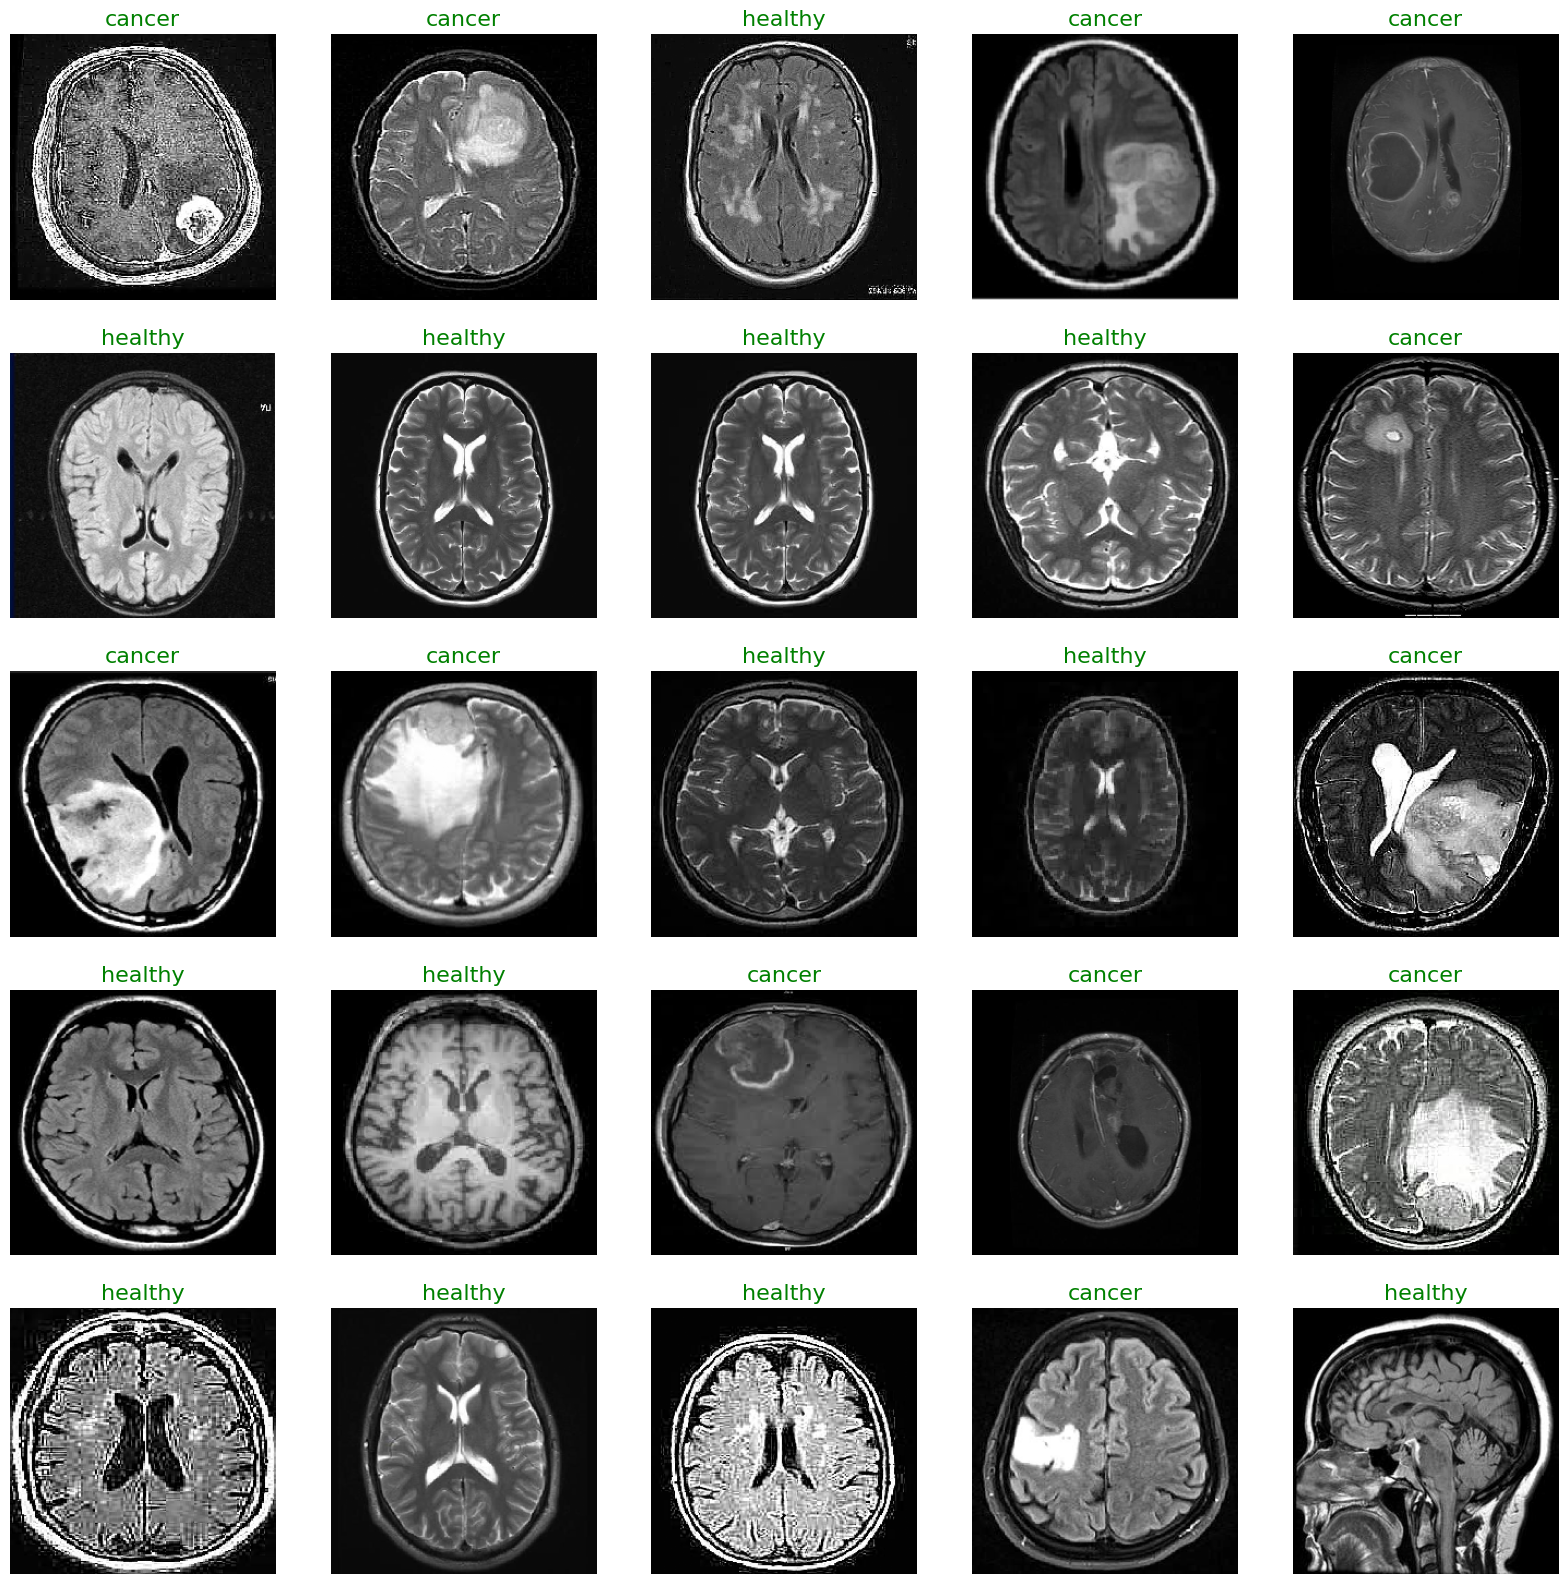

In [15]:
show_brain_images(train)

In [16]:
#Defining Sequential Model
model = Sequential()
# defining conv-pool layer
model.add(Conv2D(filters=32,kernel_size=(3,3),strides=(1,1), activation="relu", padding="valid",
               input_shape=(244,244,3)))
model.add(MaxPooling2D(pool_size=(2,2)))

#adding flatten layer
model.add(Flatten())

#adding dense layers with dropout
model.add(Dense(128, activation='relu'))
model.add(Dropout(rate=0.3))
model.add(Dense(64, activation="relu"))

#Output layer
model.add(Dense(2, activation="sigmoid")) #Sigmoid is used for binary. Use Softmax for Mutliclass.

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
#Summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 242, 242, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 121, 121, 32)      0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 468512)            0         
                                                                 
 dense (Dense)               (None, 128)               59969664  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                        

In [17]:
#fitting model
History = model.fit(train, validation_data= val, epochs=10,verbose=1)

Epoch 1/10
115/115 [==============================] - 277s 2s/step - loss: 2.1592 - accuracy: 0.6557 - val_loss: 0.4342 - val_accuracy: 0.8446
Epoch 2/10
115/115 [==============================] - 278s 2s/step - loss: 0.3899 - accuracy: 0.8296 - val_loss: 0.2510 - val_accuracy: 0.9033
Epoch 3/10
115/115 [==============================] - 280s 2s/step - loss: 0.2156 - accuracy: 0.9179 - val_loss: 0.1612 - val_accuracy: 0.9348
Epoch 4/10
115/115 [==============================] - 279s 2s/step - loss: 0.1405 - accuracy: 0.9492 - val_loss: 0.1273 - val_accuracy: 0.9587
Epoch 5/10
115/115 [==============================] - 272s 2s/step - loss: 0.0883 - accuracy: 0.9717 - val_loss: 0.1282 - val_accuracy: 0.9554
Epoch 6/10
115/115 [==============================] - 279s 2s/step - loss: 0.0714 - accuracy: 0.9780 - val_loss: 0.1235 - val_accuracy: 0.9554
Epoch 7/10
115/115 [==============================] - 277s 2s/step - loss: 0.1356 - accuracy: 0.9546 - val_loss: 0.1235 - val_accuracy: 0.9533

Text(0.5, 1.0, 'Training and Validation Accuracy')

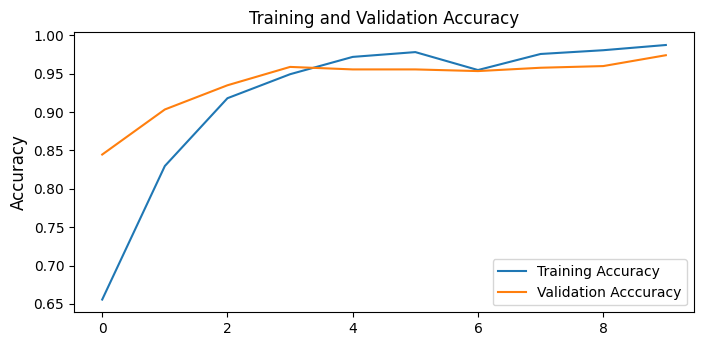

In [18]:
acc = History.history["accuracy"] # report of model
val_acc = History.history["val_accuracy"] # history of validation data

loss = History.history["loss"]        # Training loss
val_loss = History.history["val_loss"] # validation loss

plt.figure(figsize=(8,8))
plt.subplot(2,1,1) # 2 rows and 1 columns
#plotting respective accuracy
plt.plot(acc,label="Training Accuracy")
plt.plot(val_acc, label="Validation Acccuracy")

plt.legend()
plt.ylabel("Accuracy", fontsize=12)
plt.title("Training and Validation Accuracy", fontsize=12)

Text(0.5, 1.0, 'Training and Validation Losses')

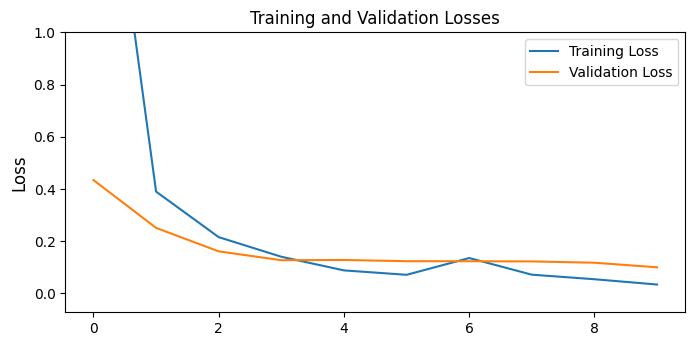

In [19]:
plt.figure(figsize=(8,8))
plt.subplot(2,1,1)

plt.plot(loss, label="Training Loss")      #Training loss
plt.plot(val_loss, label="Validation Loss") # Validation Loss

plt.legend()
plt.ylim([min(plt.ylim()),1])
plt.ylabel("Loss", fontsize=12)
plt.title("Training and Validation Losses", fontsize=12)

In [20]:
model.evaluate(test, verbose=1)

44/44 [==============================] - 24s 544ms/step - loss: 0.0671 - accuracy: 0.9826


[0.06708507239818573, 0.9826086759567261]

In [21]:
pred = model.predict(test)
pred = np.argmax(pred, axis=1) #pick class with highest  probability

labels = (train.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred2 = [labels[k] for k in pred]

44/44 [==============================] - 24s 510ms/step


In [27]:
from sklearn.metrics import accuracy_score

y_test = test_images.labels # set y_test to the expected output
print(classification_report(y_test, pred2))
print("Accuracy of the Model:",accuracy_score(y_test, pred2)*100,"%")

              precision    recall  f1-score   support

      cancer       0.98      0.98      0.98       779
     healthy       0.98      0.98      0.98       601

    accuracy                           0.98      1380
   macro avg       0.98      0.98      0.98      1380
weighted avg       0.98      0.98      0.98      1380

Accuracy of the Model: 98.26086956521739 %


<Axes: >

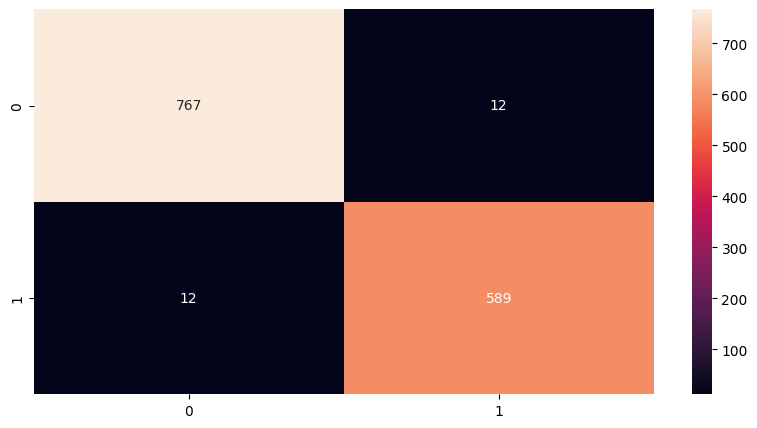

In [28]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix, accuracy_score
plt.figure(figsize = (10,5))
cm = confusion_matrix(y_test, pred2)
sns.heatmap(cm, annot=True, fmt = 'g')